# Inicialización de librerías y funciones

In [2]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras import backend as K
import pickle
import shap
shap.initjs()

In [3]:
# Importamos el dataset con los datos preprocesados
df = pd.read_csv('Data/Datasets/PreprocessedDataset.csv', sep=',')
# Importamos el dataset con los datos preprocesados pero sin estandarizar
df_filled = pd.read_csv('Data/Datasets/FilledDataset.csv',sep=',')

In [4]:
# División en conjunto de entrenamiento y test y separación de la variable objetivo
X = df.drop(columns=['Life Expectancy'])
y = df['Life Expectancy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [5]:
# Cargamos los scalers para hacer y deshacer las transformaciones
scalerLE = pickle.load(open('Data/Scalers/LE_Scaler.pkl', 'rb'))
scaler_total = pickle.load(open('Data/Scalers/Normal_Features_Scaler.pkl', 'rb'))
power_YJ = pickle.load(open('Data/Scalers/Yeo-Johnson_Scaler.pkl', 'rb'))

In [6]:
# Función para poder calcular el error R2 al entrenar la red de neuronas
def r2_score_metric(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [7]:
#Importar Red de Neuronas
NN_model = tf.keras.models.load_model('Data/Models/NN_Model.h5', compile=False)
NN_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['mae', 'mse', r2_score_metric])

In [8]:
# Creamos el explainer de SHAP
explainer = shap.DeepExplainer(NN_model, np.array(X_train))
# Cargamos los shap_values de un CSV
shap_values = []
shap_values.append(np.loadtxt('Data/SHAP_values.csv', delimiter=','))

In [9]:
#Creamos las listas de las features que se van a transformar
columnsYJ = list(df.columns)
columnsYJ.remove('Male')
columnsYJ.remove('Female')
columnsYJ.remove('Life Expectancy')

featuresScale = ['Life Expectancy', '% Death Cardiovascular','Tobacco Prevalence','Road Traffic Deaths','% Injury Deaths',
            'Government Expenditure Education', 'Government Expenditure Health', 'Diet Composition Cereals And Grains',
            'Diet Composition Fruit And Vegetables', 'Diet Composition Oils And Fats', 'Diet Calories Plant Protein',
            'Diet Calories Carbohydrates']

In [10]:
def applyTransformations(d):
    data = d.copy()
    if('Country' in data.columns):
        data.drop(columns=['Country'], inplace=True)
    data.insert(loc=1,column='Female',value=data['Gender'].apply(lambda gender: 0 if gender == 'Male' else 1))
    data.insert(loc=2,column='Male',value=data['Gender'].apply(lambda gender: 0 if gender == 'Female' else 1))
    data.drop(columns=['Gender'], inplace=True)

    data[featuresScale] = scaler_total.transform(data[featuresScale])
    data[columnsYJ] = power_YJ.transform(data[columnsYJ])
    data.drop(columns=['Life Expectancy'], inplace=True)
    return data

In [11]:
def predictLifeExpectancy(data):
    #Calculamos la esperanza de vida mediante la Red de Neuronas
    life_expectancy = NN_model.predict(data)
    return scalerLE.inverse_transform(life_expectancy).flatten()[0]

In [12]:
def getData(country, year, gender):
    # country: Nombre del país en inglés
    # year: Rango dentro del intervalo [1990, 2019]
    # gender:Posibles valores: Male, Female y Both sexes
    data = df_filled[(df_filled['Country'] == country)&(df_filled['Year'] == year)&(df_filled['Gender'] == gender)]
    return data

In [13]:
def getLifeExpectancy(country, year, gender):
    case = applyTransformations(getData(country = country, year = year, gender = gender))
    life_expectancy = predictLifeExpectancy(case)
    return life_expectancy

In [14]:
def compareLifeExpectancy(dataOriginal, data):
    print(f"País: {dataOriginal['Country'].iloc[0]}. Año: {int (dataOriginal['Year'].iloc[0])}. Género: {dataOriginal['Gender'].iloc[0]}")
    print(f"Esperanza de vida real: {dataOriginal['Life Expectancy'].iloc[0]}")
    print(f"Esperanza de vida según el predictor: {predictLifeExpectancy(applyTransformations(dataOriginal))}")
    print(f"Esperanza de vida tras los cambios: {predictLifeExpectancy(applyTransformations(data))}")

# Predictor desde cero

In [15]:
# Establecer valores de los indicadores(actualmente con la media para valor de referencia)
data = pd.DataFrame({
    'Life Expectancy': [0],
    'Year': [2004.5],
    'Gender': ['Both sexes'],
    '% Death Cardiovascular': [21.714996698846615],
    'Low CI Value % Death Cardiovascular': [16.022463118457104],
    'High CI Value % Death Cardiovascular': [28.254232762348398],
    'Suicides Rate': [10.41299712499964],
    'Alcohol Abuse': [6.499947964227886],
    'Poisoning Mortality Rate': [1.3268144314222243],
    'Tobacco Prevalence': [25.395881879161788],
    '% of Births Attended By Skilled Personal': [81.32626339176532],
    'Incidence of Malaria': [64.20754328482724],
    'Incidence of Tuberculosis': [140.46949115059812],
    'Low CI Value Incidence of Tuberculosis': [95.17187417755024],
    'High CI Value Incidence of Tuberculosis': [195.5725712255296],
    'Road Traffic Deaths': [16.565513800643878],
    'Adolescent Birth Rate': [56.94777730096763],
    'Universal Heath Care Coverage': [64.4356169598515],
    'Population 10 Percentage SDG Total': [8.572232830536127],
    'Population 10 Percentage SDG Urban': [8.283076877471244],
    'Population 10 Percentage SDG Rural': [8.591446619793631],
    'Population 25 Percentage SDG Total': [1.6997306732578121],
    'Population 25 Percentage SDG Urban': [1.5958009441474885],
    'Population 25 Percentage SDG Rural': [1.7572668555264856],
    'Doctors': [15.58205844446565],
    'Nurses and Midwifes': [37.0210763319035],
    'Dentists': [2.9304671826574853],
    'Pharmacists': [3.2557651823522136],
    'Basic Drinking Water Services': [77.66098056850947],
    'Basic Sanization Services Total': [71.20613532292053],
    'Basic Sanization Services Urban': [77.4377975591365],
    'Basic Sanization Services Rural': [64.74757355732659],
    'Safely Sanitation Total': [49.155901585797565],
    'Safely Sanitation Urban': [52.595522138171894],
    'Safely Sanitation Rural': [49.30425649960815],
    'Basic Hand Washing Total': [67.2688207322555],
    'Basic Hand Washing Urban': [73.25346049909675],
    'Basic Hand Washing Rural': [62.64619164301689],
    'Clean Fuel and Technology': [62.80444667364819],
    'Birth Rate': [23.438986690941082],
    '% Injury Deaths': [9.02760834493537],
    'GDP per Capita': [12497.06606682043],
    '% Population $1.90 a day': [16.344255317509305],
    '% Population $3.20 a day': [29.27054713541028],
    '% Population $5.50 a day': [44.20904826422448],
    'Income per Capita': [8229.058384677826],
    'GNI per Capita': [11557.879347985147],
    'Homicide Rate': [8.196805153920502],
    'Government Expenditure Education': [14.95192157847963],
    'Government Expenditure Military': [7.063402450833477],
    'Government Expenditure Health': [3.608602976934906],
    'Diet Composition Alcoholic Beverages': [77.88558239636964],
    'Diet Composition Other': [34.86229387224017],
    'Diet Composition Sugar': [282.03831836008777],
    'Diet Composition Oils And Fats': [394.39645388752365],
    'Diet Composition Meat': [239.61978121570428],
    'Diet Composition Dairy And Eggs': [188.6116635961729],
    'Diet Composition Fruit And Vegetables': [158.49532242821326],
    'Diet Composition Starchy Roots': [171.8076456804966],
    'Diet Composition Pulses': [54.77087078160444],
    'Diet Composition Cereals And Grains': [1102.1816316235488],
    'Vegetable Consumption': [80.32247949548179],
    'Fruit Consumption Plantains': [12.331262632745114],
    'Fruit Consumption Other': [21.367521346399922],
    'Fruit Consumption Bananas': [13.898478687879086],
    'Fruit Consumption Dates': [1.451219457262188],
    'Fruit Consumption Other Citrus': [1.3123878149291959],
    'Fruit Consumption Oranges And Mandarines': [14.483484391536996],
    'Fruit Consumption Apples': [8.644773581778862],
    'Fruit Consumption Lemons And Limes': [2.0181941057473316],
    'Fruit Consumption Grapes': [4.5181093362040565],
    'Fruit Consumption Grapefruit': [2.640305541041973],
    'Fruit Consumption Pineapples': [2.943169986055564],
    'Cereal Consumption Oats': [4.523805407438411],
    'Cereal Consumption Rye': [14.630684340286177],
    'Cereal Consumption Barley': [11.991290367242303],
    'Cereal Consumption Sorghum': [48.893753655574564],
    'Cereal Consumption Maize': [177.9565609772109],
    'Cereal Consumption Wheat': [540.0885737338322],
    'Cereal Consumption Rice': [286.69928798420614],
    'Diet Calories Animal Protein': [133.39688568560715],
    'Diet Calories Plant Protein': [169.88439904816065],
    'Diet Calories Fat': [710.6087452726576],
    'Diet Calories Carbohydrates': [1694.138759630824],
    'Intervention Against NTDs per capita': [0.25625747955868],
    'Battle Related Deaths %': [4.4375105593365616e-05],
    'Conflict and Terrorism Deaths %': [3.5997223645652325e-05]
    })

In [16]:
print('Los datos son:')
data.drop('Life Expectancy', axis=1)

Los datos son:


,Year,Gender,% Death Cardiovascular,Low CI Value % Death Cardiovascular,High CI Value % Death Cardiovascular,Suicides Rate,Alcohol Abuse,Poisoning Mortality Rate,Tobacco Prevalence,% of Births Attended By Skilled Personal,Incidence of Malaria,Incidence of Tuberculosis,Low CI Value Incidence of Tuberculosis,High CI Value Incidence of Tuberculosis,Road Traffic Deaths,Adolescent Birth Rate,Universal Heath Care Coverage,Population 10 Percentage SDG Total,Population 10 Percentage SDG Urban,Population 10 Percentage SDG Rural,Population 25 Percentage SDG Total,Population 25 Percentage SDG Urban,Population 25 Percentage SDG Rural,Doctors,Nurses and Midwifes,Dentists,Pharmacists,Basic Drinking Water Services,Basic Sanization Services Total,Basic Sanization Services Urban,Basic Sanization Services Rural,Safely Sanitation Total,Safely Sanitation Urban,Safely Sanitation Rural,Basic Hand Washing Total,Basic Hand Washing Urban,Basic Hand Washing Rural,Clean Fuel and Technology,Birth Rate,% Injury Deaths,GDP per Capita,% Population $1.90 a day,% Population $3.20 a day,% Population $5.50 a day,Income per Capita,GNI per Capita,Homicide Rate,Government Expenditure Education,Government Expenditure Military,Government Expenditure Health,Diet Composition Alcoholic Beverages,Diet Composition Other,Diet Composition Sugar,Diet Composition Oils And Fats,Diet Composition Meat,Diet Composition Dairy And Eggs,Diet Composition Fruit And Vegetables,Diet Composition Starchy Roots,Diet Composition Pulses,Diet Composition Cereals And Grains,Vegetable Consumption,Fruit Consumption Plantains,Fruit Consumption Other,Fruit Consumption Bananas,Fruit Consumption Dates,Fruit Consumption Other Citrus,Fruit Consumption Oranges And Mandarines,Fruit Consumption Apples,Fruit Consumption Lemons And Limes,Fruit Consumption Grapes,Fruit Consumption Grapefruit,Fruit Consumption Pineapples,Cereal Consumption Oats,Cereal Consumption Rye,Cereal Consumption Barley,Cereal Consumption Sorghum,Cereal Consumption Maize,Cereal Consumption Wheat,Cereal Consumption Rice,Diet Calories Animal Protein,Diet Calories Plant Protein,Diet Calories Fat,Diet Calories Carbohydrates,Intervention Against NTDs per capita,Battle Related Deaths %,Conflict and Terrorism Deaths %
0,2004.5,Both sexes,21.714997,16.022463,28.254233,10.412997,6.499948,1.326814,25.395882,81.326263,64.207543,140.469491,95.171874,195.572571,16.565514,56.947777,64.435617,8.572233,8.283077,8.591447,1.699731,1.595801,1.757267,15.582058,37.021076,2.930467,3.255765,77.660981,71.206135,77.437798,64.747574,49.155902,52.595522,49.304256,67.268821,73.25346,62.646192,62.804447,23.438987,9.027608,12497.066067,16.344255,29.270547,44.209048,8229.058385,11557.879348,8.196805,14.951922,7.063402,3.608603,77.885582,34.862294,282.038318,394.396454,239.619781,188.611664,158.495322,171.807646,54.770871,1102.181632,80.322479,12.331263,21.367521,13.898479,1.451219,1.312388,14.483484,8.644774,2.018194,4.518109,2.640306,2.94317,4.523805,14.630684,11.99129,48.893754,177.956561,540.088574,286.699288,133.396886,169.884399,710.608745,1694.13876,0.256257,0.000044,0.000036


In [17]:
# Obtenemos los SHAP values del caso a estudiar
case = applyTransformations(data)
shap_values_case = explainer.shap_values(np.array(case))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


La esperanza de vida según los indicadores elegidos es de 75.07697296142578 años.
La explicación de la aportación de cada indicador según SHAP es:


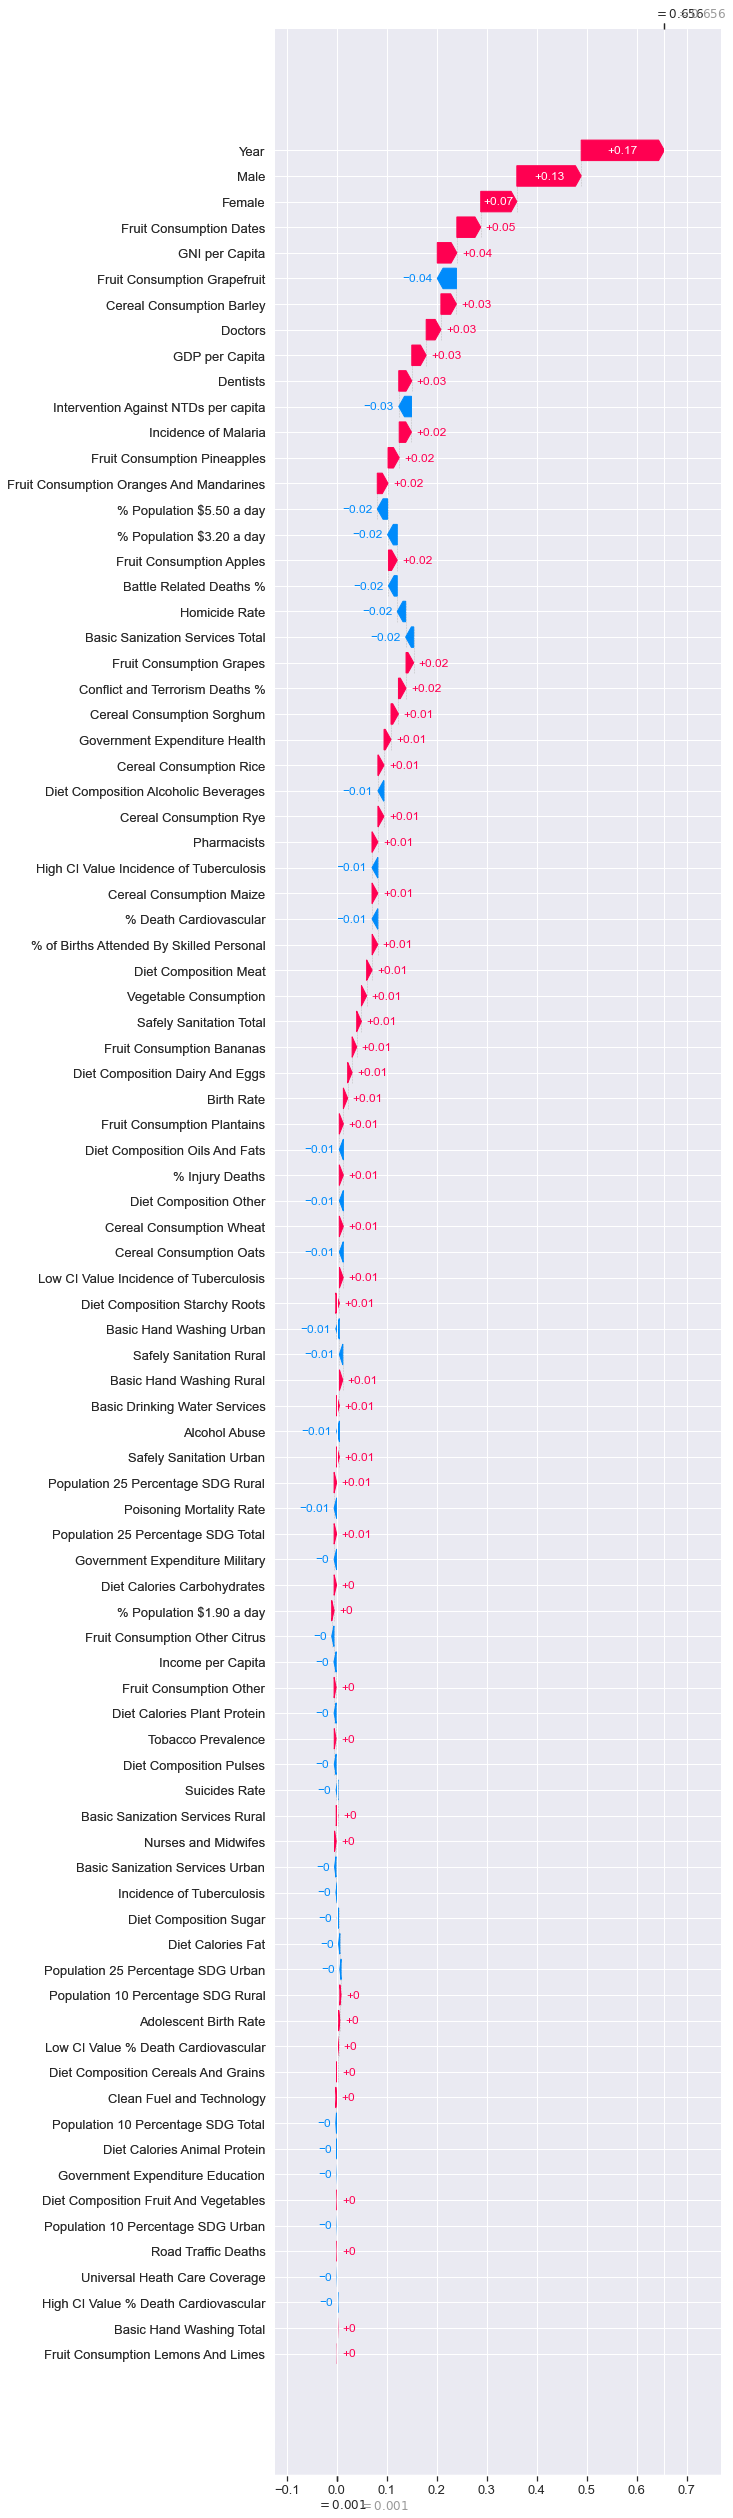

In [18]:
print(f'La esperanza de vida según los indicadores elegidos es de {predictLifeExpectancy(case)} años.')
print('La explicación de la aportación de cada indicador según SHAP es:')
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values_case[0][0], feature_names=X.columns, max_display=X.shape[1])